## 2-4-2. Feature Selection Using Hybrid Method (Recursive feature elimination)

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

4) If the metric decreases by more than an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been evaluated.

I call this a hybrid method because:

- it derives the importance derived from the machine learning algorithm, like embedded methods

- it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice, it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop, the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem.

### A. Import Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split

### B. Set City Name and Import City Data

In [2]:
# set city name
city_data = "1_goyang_city.xlsx"
CITY_NAME_Eng = "GoYang-City"

In [3]:
# Read excel file using pandas
df = pd.read_excel(open(f"../../data/{city_data}", 'rb'), sheet_name="training", header=4, index_col=0)
# Remove unnecessary columns for this analysis
df = df.iloc[2:]
# Change Date Format and Set Date as index
df.index = pd.to_datetime(df.index.str.strip(), format='%Y-%m')
df.index.name = "date"
# Change data format from "Object" to "Float"
df["water_supply"] = df.water_supply.astype(float)
df["Total_Population"] = df.Total_Population.astype(float)
# Delete unnecessary columns 
df.drop(columns=df.columns[19:21], inplace=True)
df.drop(columns=df.columns[22:23], inplace=True)
# Select clean data
df = df.loc["2010-01-01":]
df

,water_supply,Total_Population,Households,Population_per_Households,Male_Population,Female_Population,Male_Female_Ratio,Population_aging_Ratio,Power_usage,Num_of_Business,...,personal_expense,benefits_vs_personal_expense,employment_ratio,employment_insurance_ratio,Average_Temp,Monthly_Rainfall,Average_Relative_Humadity,Ground_Temp,Average_Wind,Average_Pressure
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,282265.709677,939497.0,353741.0,2.655889,463878.0,475619.0,0.975314,0.088,434436000.0,20326.0,...,104371555.0,0.191,99001.0,0.105377,-4.5,29.3,0.65,-1.2,2.3,1013.6
2010-02-01,273685.892857,940639.0,354266.0,2.655177,464518.0,476121.0,0.975630,0.088,418156000.0,20685.0,...,104371555.0,0.191,99893.0,0.106197,1.4,55.3,0.59,1.4,2.4,1010.7
2010-03-01,269918.193548,940982.0,354003.0,2.658119,464740.0,476242.0,0.975848,0.088,346653000.0,20809.0,...,104371555.0,0.191,99678.0,0.105930,4.3,82.5,0.59,5.0,2.9,1009.6
2010-04-01,274462.700000,941737.0,354192.0,2.658832,465148.0,476589.0,0.975994,0.088,356701000.0,21857.0,...,104371555.0,0.191,101594.0,0.107879,9.5,62.8,0.54,10.8,2.9,1007.4
2010-05-01,288537.806452,941724.0,354157.0,2.659058,465110.0,476614.0,0.975863,0.089,313793000.0,21739.0,...,104371555.0,0.191,102073.0,0.108390,17.2,124.0,0.62,18.7,2.6,1000.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,354382.451613,1080896.0,454793.0,2.376677,528972.0,551924.0,0.958415,0.140,487867544.0,46416.0,...,218316665.0,0.293,171845.0,0.158984,25.9,211.2,0.74,28.2,2.1,998.6
2021-09-01,343537.800000,1080787.0,455501.0,2.372743,528911.0,551876.0,0.958387,0.141,401433572.0,45514.0,...,218316665.0,0.293,172771.0,0.159857,22.6,131.0,0.71,24.6,2.3,1003.4
2021-10-01,340126.806452,1080240.0,455845.0,2.369753,528683.0,551557.0,0.958528,0.142,358286760.0,45839.0,...,218316665.0,0.293,173486.0,0.160599,15.6,57.0,0.70,16.7,2.1,1011.0


### C. Hybrid Methods: Selection using Recursive feature elimination

* Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['water_supply'], axis=1),
    df['water_supply'],
    test_size=0.2,
    random_state=0)

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

X_train.shape, X_test.shape

((115, 24), (29, 24))

#### Build ML model with all features

In [5]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# build initial model using all the features
model_full = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate r2 in the test set
y_pred_test = model_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)

print('Test full dataset R2 = %f' % (r2_full))

Test full dataset R2 = 0.762645


#### Rank features by importance

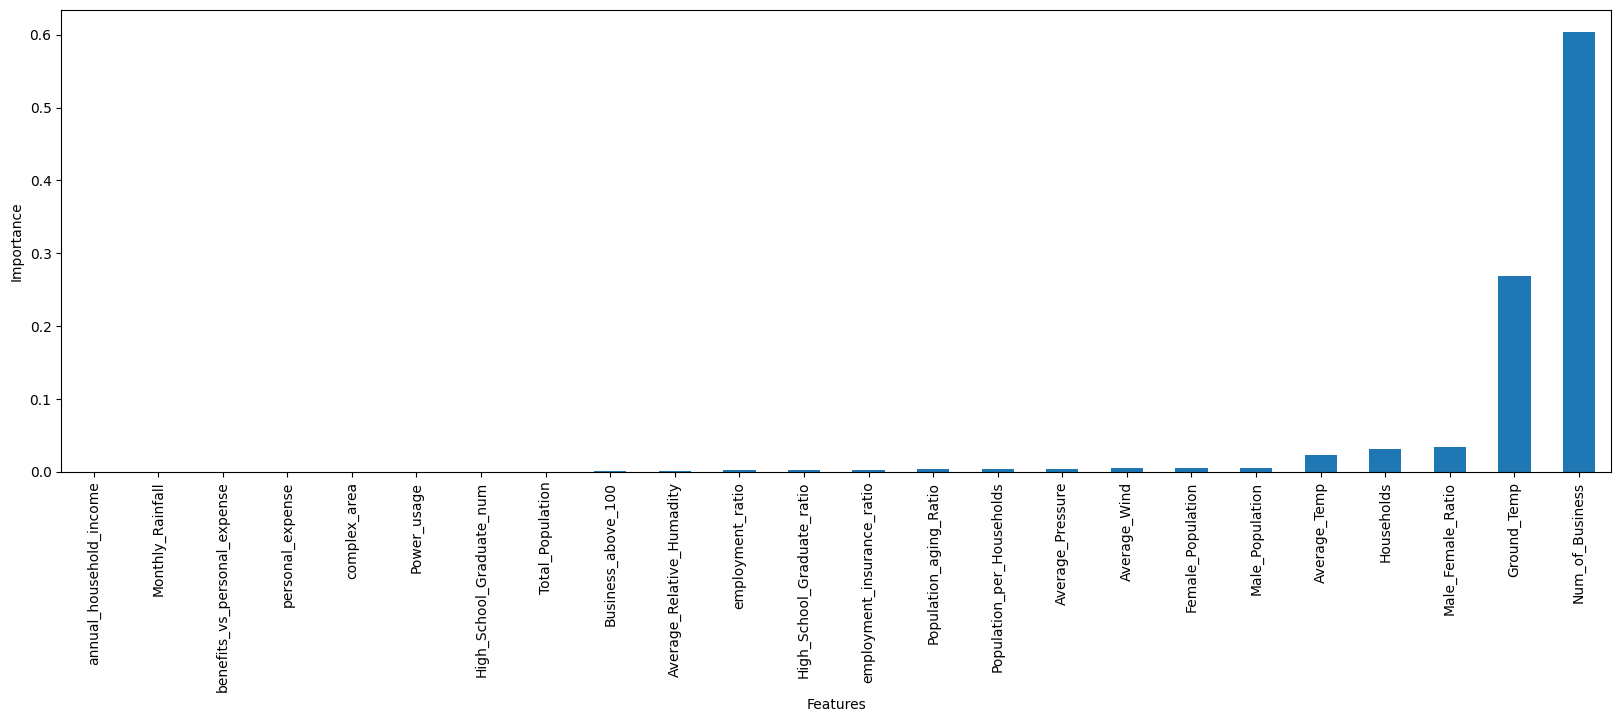

In [6]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [7]:
# make list with ordered features
features = list(features.index)
features

['annual_household_income',
 'Monthly_Rainfall',
 'benefits_vs_personal_expense',
 'personal_expense',
 'complex_area',
 'Power_usage',
 'High_School_Graduate_num',
 'Total_Population',
 'Business_above_100',
 'Average_Relative_Humadity',
 'employment_ratio',
 'High_School_Graduate_ratio',
 'employment_insurance_ratio',
 'Population_aging_Ratio',
 'Population_per_Households',
 'Average_Pressure',
 'Average_Wind',
 'Female_Population',
 'Male_Population',
 'Average_Temp',
 'Households',
 'Male_Female_Ratio',
 'Ground_Temp',
 'Num_of_Business']

#### Select features

In [8]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build model at each round.

# once we build the model, we calculate the new r2
# if the new r2 is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in r2
# if the drop is below this threshold,
# the feature will be removed
tol = 0.001

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # calculate the new r2
    r2_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_int)))

    # print the original r2 with all the features
    print('All features Test r2 = {}'.format((r2_full)))

    # determine the drop in the r2
    diff_r2 = r2_full - r2_int

    # compare the drop in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_full = r2_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  annual_household_income 1  out of  24
New Test r2 = 0.7668122608366489
All features Test r2 = 0.7626452513759286
Drop in r2 = -0.004167009460720239
remove:  annual_household_income

testing feature:  Monthly_Rainfall 2  out of  24
New Test r2 = 0.765704778797544
All features Test r2 = 0.7668122608366489
Drop in r2 =0.0011074820391049345
keep:  Monthly_Rainfall

testing feature:  benefits_vs_personal_expense 3  out of  24
New Test r2 = 0.7643777222955199
All features Test r2 = 0.7668122608366489
Drop in r2 =0.002434538541128961
keep:  benefits_vs_personal_expense

testing feature:  personal_expense 4  out of  24
New Test r2 = 0.7643777222955199
All features Test r2 = 0.7668122608366489
Drop in r2 =0.002434538541128961
keep:  personal_expense

testing feature:  complex_area 5  out of  24
New Test r2 = 0.7641069054057152
All features Test r2 = 0.7668122608366489
Drop in r2 =0.0027053554309336425
keep:  complex_area

testing feature:  

In [9]:
features_to_keep

['Monthly_Rainfall',
 'benefits_vs_personal_expense',
 'personal_expense',
 'complex_area',
 'High_School_Graduate_ratio',
 'employment_insurance_ratio',
 'Population_aging_Ratio',
 'Population_per_Households',
 'Average_Pressure',
 'Average_Wind',
 'Female_Population',
 'Male_Population',
 'Average_Temp',
 'Households']

In [10]:
results_f = pd.DataFrame()
results_f["hybrid RFE"] = [features_to_keep]
results_f.to_csv(f'./results/{CITY_NAME_Eng}_hybrid_RFE_results.csv')
results_f

,hybrid RFE
0,"[Monthly_Rainfall, benefits_vs_personal_expens..."


In [11]:
# finally let's test the performance of the model 
# built on the selected features

# build initial model
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict(X_test[features_to_keep])

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.796552
